# Ajuste por IFT de un controlador PI

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sympy as sp
import control as ctrl

In [ ]:
# ----------------------------
# Calculo el vector Delta
# ----------------------------
# Luego tengo que tomar el algortimo y copiarlo en la iteración IFT
kp, ki, q = sp.symbols('kp ki q')

R = kp * (1+ki - q**(-1))/(1-q**(-1))
R = sp.simplify(R)

dR_dkp = sp.diff(R,kp)
dR_dki = sp.diff(R,ki)

Delta = 1/R * sp.Matrix([dR_dkp,dR_dki]) 

print("Regulador: ")
sp.pprint(R)
print("Vector Delta: ")
sp.pprint(Delta)

Regulador: 
kp⋅(q⋅(ki + 1) - 1)
───────────────────
       q - 1       
Vector Delta: 
⎡      1       ⎤
⎢      ──      ⎥
⎢      kp      ⎥
⎢              ⎥
⎢      q       ⎥
⎢──────────────⎥
⎣q⋅(ki + 1) - 1⎦


## Simulación del ajuste iterativo

Modelo de la planta
<TransferFunction>: sys[2207]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

       0.5
  -------------
  s^2 + 2 s + 1


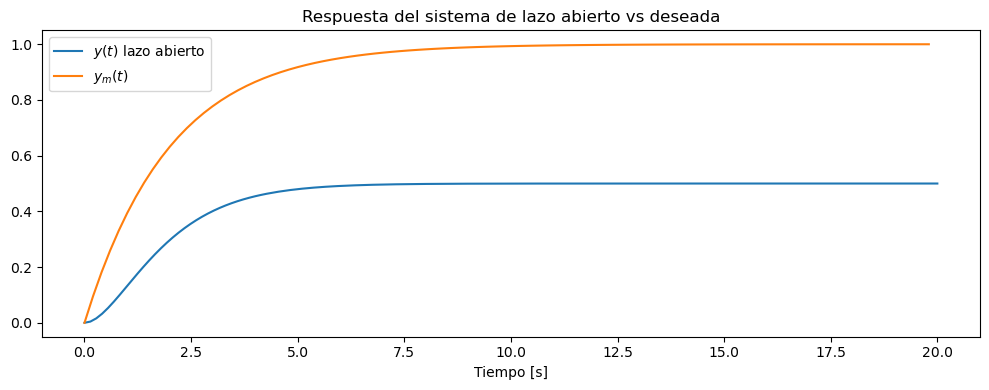

/tmp/ipykernel_1882207/2677144107.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = float(Gdss.C @ x)


Iter  1: J=1.65227, kp=1.4960, ki=0.2136
Iter  2: J=1.14022, kp=1.4929, ki=0.1805
Iter  3: J=0.72546, kp=1.4908, ki=0.1529
Iter  4: J=0.46227, kp=1.4899, ki=0.1335
Iter  5: J=0.34797, kp=1.4900, ki=0.1241
Iter  6: J=0.32546, kp=1.4907, ki=0.1216
Iter  7: J=0.32429, kp=1.4917, ki=0.1212
Iter  8: J=0.32406, kp=1.4926, ki=0.1211
Iter  9: J=0.32457, kp=1.4935, ki=0.1210
Iter 10: J=0.32263, kp=1.4944, ki=0.1209


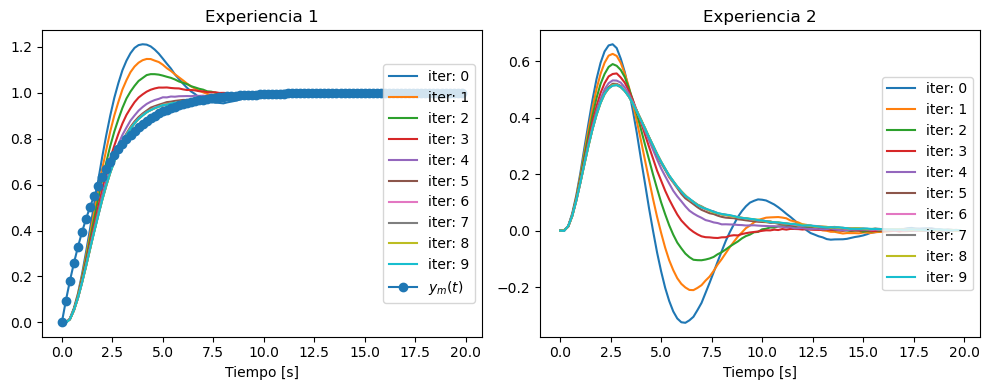

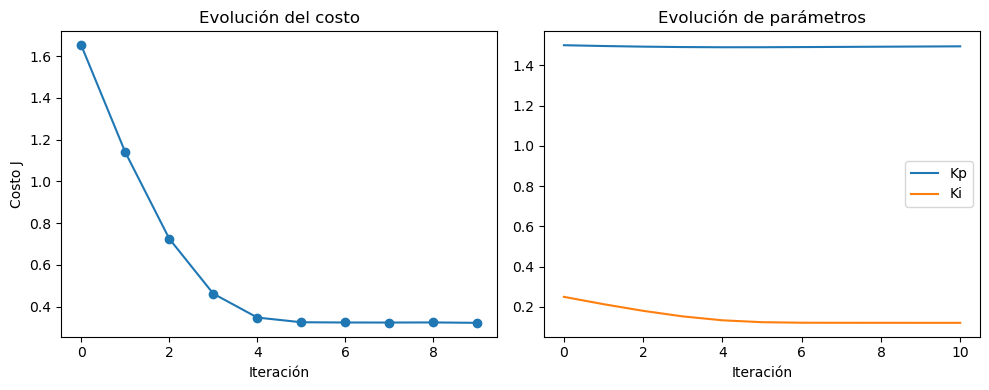

Parámetros finales: Kp = 1.4944, Ki = 0.1209


In [ ]:
# ----------------------------
# 0. Parámetros iniciales
# ----------------------------
# Ganancias iniciales del controlador
kp, ki, kd = 1.5, 0.25, 0.0

# Ganancia de aprendizaje y penalización
gamma = 0.5
lmbda = 0.0                     # probar con 0.1: se ve cómo se pierde performance pero se entrega menos energía
var = 0.001
iteraciones = 10

Tfin = 20                       # Tiempo de simulación
Ts = 0.2                        # Período de muestreo

N = int(Tfin / Ts)
t = np.arange(0, Tfin, Ts)
ref = 1.0 * np.ones_like(t)

# ----------------------------
# 1. Sistema continuo y objetivo de lazo cerrado
# ----------------------------
s = ctrl.TransferFunction.s
z = ctrl.TransferFunction.z
G = 0.5/(s**2+2*s+1)
Gd = ctrl.sample_system(G,Ts=Ts,method='zoh')
Gdss = ctrl.tf2ss(Gd)
print("Modelo de la planta")
print(G)

# Respuesta al escalón (solo informativa)
t_cont, y_cont = ctrl.step_response(G, T=Tfin)

# Modelo deseado (respuesta de referencia)
Gcl_m = 1/(2*s+1)
_, ym = ctrl.step_response(Gcl_m, T=t)

plt.figure(figsize=(10,4))
plt.plot(t_cont,y_cont,label='$y(t)$ lazo abierto')
plt.plot(t,ym,label='$y_m(t)$')
plt.xlabel('Tiempo [s]')
plt.title('Respuesta del sistema de lazo abierto vs deseada')
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# 2. Función de simulación
# ----------------------------
def simular_respuesta(t, ref, kp, ki, ruido=False):    
    # Simula el lazo cerrado PI en tiempo discreto
    x = np.zeros((Gdss.A.shape[0],1))
    N = len(t)
    y = np.zeros_like(t)
    u = np.zeros_like(t)
    e = np.zeros_like(t)
    for i in range(2, N):
        if ruido:
            y[i-1] += var * np.random.randn()
        e[i] = ref[i-1] - y[i-1]
        # ley de control del regulador R
        u[i] = u[i-1] + kp*(1+ki)*e[i] - kp*e[i-1]
        # Salida del sistema discretizado
        x = Gdss.A @ x + Gdss.B * u[i]
        y[i] = float(Gdss.C @ x)
    return y, u

# ----------------------------
# 3. Ciclo IFT
# ----------------------------
th = np.zeros((2, iteraciones + 1))
th[:, 0] = [kp, ki]
Jhist = []

plt.figure(figsize=(10,4))
for k in range(iteraciones):
    # Experimento 1
    yd1, ud1 = simular_respuesta(t, ref, kp, ki, ruido=True)
    plt.subplot(1,2,1)    
    plt.plot(t,yd1,label=f'iter: {k}')

    # Experimento 2 
    yd2, ud2 = simular_respuesta(t, ref-yd1, kp, ki, ruido=True)
    plt.subplot(1,2,2)    
    plt.plot(t,yd2,label=f'iter: {k}')    

    # Cálculo del costo
    J = np.sum((ym - yd1)**2) + lmbda * np.sum(ud1**2)
    Jhist.append(J)

    # Derivadas numéricas (sensibilidades)
    Delta1 = ctrl.tf(1/kp,1,dt=Ts)
    Delta2 = z/(z*(ki+1)-1)
    _,dydkp = ctrl.forced_response(Delta1,t,u=yd2)
    _,dydki = ctrl.forced_response(Delta2,t,u=yd2)
    _,dudkp = ctrl.forced_response(Delta1,t,u=ud2)
    _,dudki = ctrl.forced_response(Delta2,t,u=ud2)

    dydp = np.vstack([dydkp, dydki])
    dudp = np.vstack([dudkp, dudki])

    djdp = (dydp @ (yd1 - ym) + lmbda * (dudp @ ud1)) / N

    # Actualización de parámetros
    kp -= gamma * djdp[0]
    ki -= gamma * djdp[1]
    th[:, k+1] = [kp, ki]

    print(f"Iter {k+1:2d}: J={J:.5f}, kp={kp:.4f}, ki={ki:.4f}")

plt.subplot(1,2,1); plt.plot(t,ym,'-o',label='$y_m(t)$');plt.xlabel('Tiempo [s]'); plt.legend(loc='center right'); plt.title(f'Experiencia 1')
plt.subplot(1,2,2); plt.xlabel('Tiempo [s]'); plt.legend(loc='center right'); plt.title(f'Experiencia 2'); plt.tight_layout()
plt.show()

# ----------------------------
# 5. Resultados finales
# ----------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(Jhist, 'o-')
plt.xlabel('Iteración')
plt.ylabel('Costo J')
plt.title('Evolución del costo')

plt.subplot(1,2,2)
plt.plot(th[0,:], label='Kp')
plt.plot(th[1,:], label='Ki')
plt.xlabel('Iteración')
plt.legend()
plt.title('Evolución de parámetros')
plt.tight_layout()
plt.show()

print(f"Parámetros finales: Kp = {kp:.4f}, Ki = {ki:.4f}")


/tmp/ipykernel_1882207/2677144107.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = float(Gdss.C @ x)


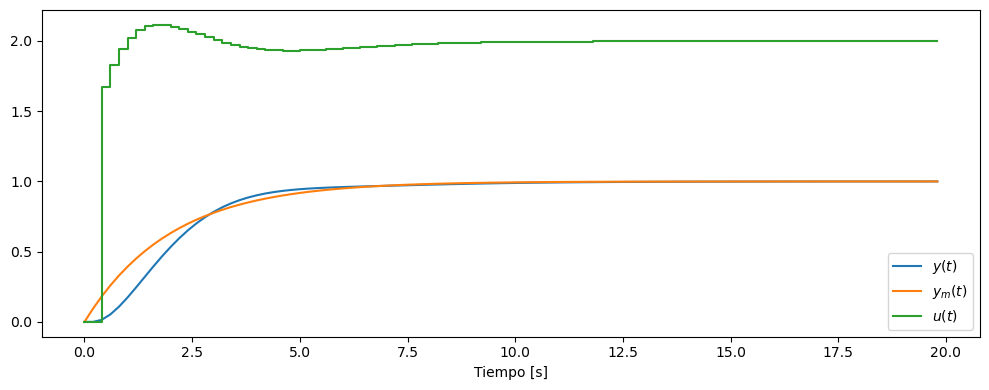

In [32]:
# Evalúo el ajuste obtenido
y, u = simular_respuesta(t, ref, kp, ki, ruido=False)
plt.figure(figsize=(10,4))
plt.plot(t,y,label='$y(t)$')
plt.plot(t,ym,label='$y_m(t)$')
plt.step(t,u,where='post',label='$u(t)$')
plt.xlabel('Tiempo [s]'); plt.legend()
plt.tight_layout()
plt.show()
